## chapter03.분류

1. MNIST
2. 이진분류기 훈련
3. 성능측정(평가방법)
4. 다중분류
5. 에러분석
6. 다중레이블 분류
7. 다중출력 분류

### 3.1 MNIST

In [56]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [57]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [58]:
#고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋을 사용하여 분류
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [59]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

즉 이미지가 70000개 있고, 각 이미지에는 784개의 특성이 있다고 볼 수가 있다. 

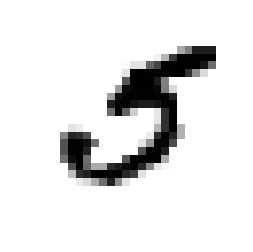

In [60]:
#데이터셋에서 이미지 하나를 확인해본다
#샘플의 특성벡터를 추출하여 28*28배열로 바꾸고 inshow()로 함수를 그린다. 
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [61]:
#위의 그래프를 실제 분류기준으로 확인하는 경우(target값으로 확인하는 경우)
y[36000]

5

In [62]:
#test, train set 나누는 과정
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [63]:
#훈련셋을 섞어 모든 교차검정폴드가 비슷해지도록 한다. 
import numpy as np
shuffle_index=np.random.permutation(60000) #인덱스를 섞어 
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index] #섞인 인덱스로 인덱싱하는 과정

### 3.2 이진분류기 훈련

In [64]:
#이진분류가 가능한 데이터셋을 만드는 과정
y_train_5=(y_train==5) #5는 TRUE, 나머지는 FALSE
y_test_5=(y_test==5)

GradientDescent 방법이 배치 방법, 즉 모든 데이터를 사용하여 분류를 수행하는 과정이었다면, SGD는 '확률적인 방법'에 초점을 맞춘다고 본다, 즉 일종의 GD의 방법이지만 '하나의 ' 데이터만을 가지고 학습을 하는 과정을 의미한다. <br>
즉 SDG는 온라인 학습에 적절하다고 본다. 

In [65]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [66]:
#위의 모델을 사용하여 숫자5의 이미지를 감지해본다. 
#앞에서 만들었던 5를가리키는 이미지 벡터의 조합 some_digits를 이용하여 예측해본다
#5예측 성공함
sgd_clf.predict([some_digit])

array([ True])

### 3.3 성능측정

3.3.1.교차검증을 이용한 정확도 측정

In [67]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #전부 아니라고 출력하는 경우

In [68]:
from sklearn.model_selection import cross_val_score
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

testset에서 전부 5가 아니라고 출력하고 비교해도 90%정확도를 나타낸다. 즉 이에 대하여 **불균형한 데이터는 정확도지표가 성능측정에 좋지 않음**을 알 수가 있다. 

In [69]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#KFOLD를 수행하지만 평가점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 

In [70]:
#confusion matrix작성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

#### 3.3.3. 정밀도와 재현율

In [71]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #정밀도

0.7687135020350381

In [72]:
recall_score(y_train_5, y_train_pred) #재현율

0.801328168234643

In [73]:
#정밀도와 재현율을 모두 포함하여 계산하는 지표 : F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

#### 3.3.4 정밀도와 재현율의 tradeoff관계
정밀도와 재현율의 임계값은 50%이다. 이 임계값을 조정하여 tradeoff관계를 조정이 가능하다. 

In [74]:
y_scores=sgd_clf.decision_function([some_digit]) #각 샘플의 점수를 입력
y_scores #점수를 기반으로 예측가능하다. 

array([161855.74572176])

In [75]:
threshold=0 #임계값의 조정

In [76]:
y_some_digit_pred=(y_scores>threshold)

In [77]:
#임계값을 높여서 측정하는 경우
threshold=200000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [78]:
#그렇다면 적절한 임계값을 설정하는 방법은?
#정밀도와 재현율의 교차지점을 구하면 된다. 
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

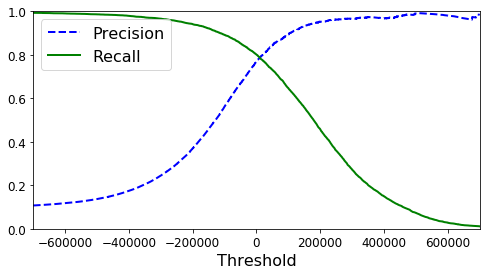

In [79]:
#시각화
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

어떤 상황이냐에 따라 정밀도를 높여야 하는지, 재현율을 높여야 하는지가 달라진다. 정밀도가 높아야 하는 경우, 어느정도 재현율을 보장하면서, 정밀도를 높일 수 있는 임계값을 구하는 것이 중요하다. 

#### 3.3.5 ROC 곡선
ROC곡선은 reciever operating characteristic 곡선이라고 한다. ROC곡선은 재현율-정밀도곡선과 비슷하되, 거짓양성비율(FPR), 진짜 양성비율(TPR)에 대한 그래프를 그린 것이다. 

In [80]:
#roc곡선 그리기 전에 roc_curve를 이용하여 여러 임계값에 대한 FPR, TPR을 먼저 구해야 한다.
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

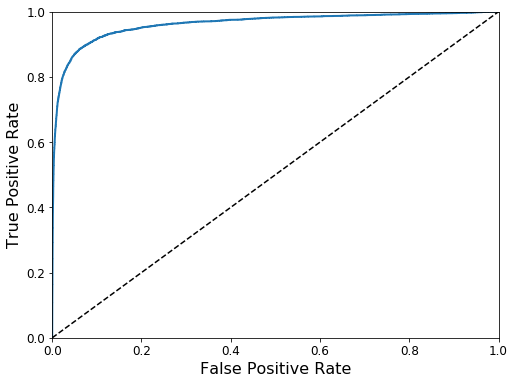

In [81]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [82]:
#AUC를 구하는 과정
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

ROC를 PR곡선보다 선택하게 되는 상황: <br>
일반적인 법칙은 양성클래스가 드물거나 거짓음성(FN)보다 거짓양성(FP)가 중요할 때, PR곡선을 사용하고 그렇지 않으면 ROC곡선을 사용한다. 

### 3.4. 다중분류

이진분류기가 2개의 class를 분류하는 것이었다면, 다중분류기는 둘 이상의 클래스를 구별하는 것<br>
- 여러개의 클래스 분류가 가능한 알고리즘 : 랜덤포레스트, 나이브 베이즈 분류기
- 이진분류만 가능한 알고리즘 : SVM, 선형분류기(GD모델 모두 해당)
- 혹은 이진분류기를 여러개 사용하여 다중 클래스 분류에 사용하기도 한다. 

여기서 이진분류기를 여러개 사용하여 다중클래스 분류에 사용하는 경우에는,다음의 방법으로 처리가 된다.  <br>
- OvA(one verses all) : 각 분류기의 결정 점수중 가장 높은 것을 클래스로 선택한다. 
- OvO(one verses one) : 0과 1의 구분, 0과 2의 구분, 1과 2의 구분..과 같이 각 숫자의 조합마다 이진 분류기를 학습시키는 것. <br>
다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 sklearn이 자동으로 감지하여 OvA를 적용한다

In [83]:
sgd_clf.fit(X_train, y_train) #SGD 학습
sgd_clf.predict([some_digit]) #예측

array([5], dtype=int8)

이 코드는 5를 구별한 타겟클래스 대신 0~9까지의 원래 타겟클래스를 사용하여 SGDClassifier을 훈련시킨다. 그 다음 예측 하나를 만든다. 이렇게 실제로 10개의 이진분류기를 훈련시키고 각각의 결정점수를 얻어 가장 점수가 높은 높은 클래스를 선택한다. <br>
이진분류기에서는 predict_proba()를 사용하기도 한다. 

In [85]:
some_digit_score=sgd_clf.decision_function([some_digit])
some_digit_score #각 teatget별 확률을 제시한다. 

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

sklearn에서는 OvO나 OvA를 사용하도록 강제하려면 OneVsOneClassifier()나 OneVsRestClassifier()를 사용해야 한다. 

In [88]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

RF와 같이 기본적으로 다중분류를 제공하는 경우에는 굳이 OvO나 OvA를 지정할 필요가 없다. 

In [115]:
#랜덤포레스트에 대한 예시 책 참고, 성능을 높이기 위한 scaling이 중요하기도 함. 

### 3.5. 에러분석

In [92]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler() #표준화 
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))

In [116]:
#다항분류작업이라 행, 열의 수가 많아진 것이고 열이 estimation, 열이 real_value에 대한 비교임은 변하지 않는다. 
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

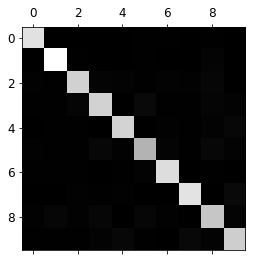

In [95]:
#시각화 
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

숫자 5는 다른 이미지들에 비해 좀더 어두워 보인다 <br>
1. 숫자 5의 이미지가 적거나
2. 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [96]:
#에러의 상대개수를 시각화 
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

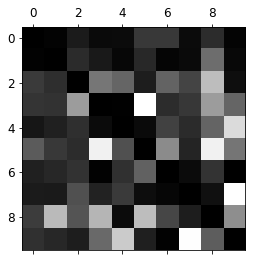

In [97]:
#다른항목은 그대로 유지하고 주 대각선만 0으로 채워서 그래프를 그리는 경우
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

오차행렬을 분석하면 분류기의 성능향상방안에 대한 통찰을 얻을 수가 있습니다. <br>
위의 경우에는 3과 5가 서로 혼돈되는 것을 보완하고 8과 9를 더 잘 분류할 수 있도록 개선하는 것이 필요하다고 생각한다. 

In [110]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

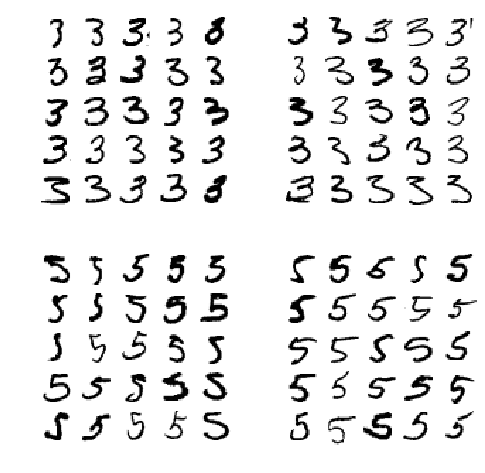

In [101]:
#혼동되어 에러로 구분되었던 값들을 각각 시각화 
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

잘못분류한 것의 일부는 정말 잘못분류되어있기 때문이고, 주된 원인은 **선형모델인 SGDClassifier을 사용했기 때문이다** 선형분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치의 합을 클래스 점수로 계산하는 형태의 boosting방식을 사용하는 데 3,5는 몇개의 픽셀만 다르기 때문에 모델이 혼동되기 쉽다. 

### 3.5. 다중레이블 분류

한 샘플내 여러개의 레이블이 존재하는 경우를 의미한다, 

In [103]:
from sklearn.neighbors import KNeighborsClassifier

#다중레이블에 속하는 조건을 넣는 경우 
y_train_large=(y_train>=7) #큰 수인가
y_train_odd=(y_train%2==1) #홀수인가 
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier() #KNN
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [105]:
knn_clf.predict([some_digit]) #예측

array([[False,  True]])

In [106]:
#평가
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.97709078477525

위의 경우는 average='marco'로 주었다. 즉 다중레이블 분류시에 각 레이블의 weight를 모두 동일하게 주었다는 의미가 될 수가 있다. 이에 대해 만약 지지도(타깃 레이블에 속한 샘플수)를 가중치로 둔다면 average='weight'로 바꿔서 돌리면 가능하다. 

### 3.7.다중출력분류

다중출력분류란 다중 레이블분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것을 의미한다.-***다중 레이블 분류와의 차이점??일반화의 의미??*** 즉 분류기의 출력이 다중레이블이고 각 레이블은 여러개의 값을 가지므로 이 예는 다중출력분류시스템이다. 

In [107]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [112]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

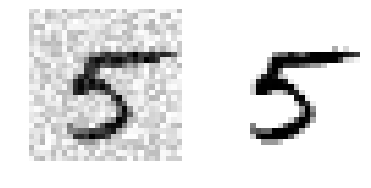

In [113]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

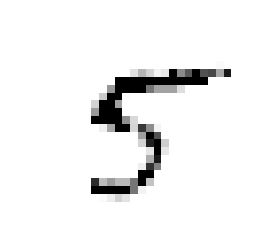

In [114]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)